## Business Understanding

## Data Understanding

### Data Preparation

In [1]:
#import appropriate libraries for analysis and visualization
import pandas as pd
import sqlite3
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### 1. Load Data to Dataframes

In [2]:
conn = sqlite3.connect('Data\im.db')
df = pd.read_sql('''SELECT  movie_id, title, region, start_year, runtime_minutes, 
                            genres, averagerating, numvotes, language, types
                            FROM movie_basics LEFT JOIN 
                             (SELECT * FROM movie_akas LEFT JOIN movie_ratings USING(movie_id))
                             USING(movie_id)''', conn)
df = df[~df['averagerating'].isna()]

In [3]:
#Load all csv and tsc files into dataframe
df1 = pd.read_csv('Data/bom.movie_gross.csv')
df2 = pd.read_csv('Data/tmdb.movies.csv', parse_dates = ['release_date'])
df3 = pd.read_csv('Data/tn.movie_budgets.csv', parse_dates = ['release_date'])
df4 = pd.read_csv('Data/rt.movie_info.tsv', sep = '\t', parse_dates = ['theater_date','dvd_date'])
df5 = pd.read_csv('Data/rt.reviews.tsv', sep = '\t', encoding='unicode_escape', parse_dates = ['date'])


#### 2. Cleaning Dataframes

##### df1

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [5]:
df1.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [6]:
#replace Nan values in foreign_gross with zero
df1['foreign_gross'].fillna(0, inplace = True)
df1['domestic_gross'].fillna(0, inplace = True)
df1['studio'].fillna('N/A', inplace = True)

#convert string types columns such as gross and box_office into float types
df1['foreign_gross'] = df1['foreign_gross'].replace('[\$,]', '', regex=True).astype(float)

#create new column total_gross which is the sum of domestic gross and foreign gross
df1['total_gross'] = df1['domestic_gross'] + df1['foreign_gross']


In [7]:
# There should be no more Nan in df1
df1.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
total_gross       0
dtype: int64

##### df2

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         26517 non-null  int64         
 1   genre_ids          26517 non-null  object        
 2   id                 26517 non-null  int64         
 3   original_language  26517 non-null  object        
 4   original_title     26517 non-null  object        
 5   popularity         26517 non-null  float64       
 6   release_date       26517 non-null  datetime64[ns]
 7   title              26517 non-null  object        
 8   vote_average       26517 non-null  float64       
 9   vote_count         26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.0+ MB


In [9]:
df2.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

##### df3

In [10]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


In [11]:
df3.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [12]:
#convert string types columns into float types
df3['production_budget'] = df3['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df3['domestic_gross'] = df3['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
df3['worldwide_gross'] = df3['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

#Create ROI column: ROI = (earnings - budget)/budget
df3['ROI'] = (df3['worldwide_gross']-df3['production_budget'])/df3['production_budget']


##### df4 

In [13]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1560 non-null   int64         
 1   synopsis      1498 non-null   object        
 2   rating        1557 non-null   object        
 3   genre         1552 non-null   object        
 4   director      1361 non-null   object        
 5   writer        1111 non-null   object        
 6   theater_date  1201 non-null   datetime64[ns]
 7   dvd_date      1201 non-null   datetime64[ns]
 8   currency      340 non-null    object        
 9   box_office    340 non-null    object        
 10  runtime       1530 non-null   object        
 11  studio        494 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 146.4+ KB


In [14]:
#filter only keep important columns
df4 = df4[['id', 'rating','genre','director','writer','studio']]

In [15]:
df4.isna().sum()

id             0
rating         3
genre          8
director     199
writer       449
studio      1066
dtype: int64

In [16]:
#For categorical columns with large Nan, I will replace with N/A
df4.fillna({'director':'N/A','writer':'N/A','studio':'N/A'}, inplace = True)
df4.isna().sum()

id          0
rating      3
genre       8
director    0
writer      0
studio      0
dtype: int64

##### df5

In [17]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          54432 non-null  int64         
 1   review      48869 non-null  object        
 2   rating      40915 non-null  object        
 3   fresh       54432 non-null  object        
 4   critic      51710 non-null  object        
 5   top_critic  54432 non-null  int64         
 6   publisher   54123 non-null  object        
 7   date        54432 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 3.3+ MB


In [18]:
df5 = df5[['id','rating','fresh']]

In [19]:
df5.isna().sum()

id            0
rating    13517
fresh         0
dtype: int64

In [20]:
df5[['rating','fresh']].value_counts()

rating  fresh 
3/5     fresh     3987
4/5     fresh     3670
3/4     fresh     3572
2/5     rotten    3139
2/4     rotten    2651
                  ... 
3.7     rotten       1
3.8/10  rotten       1
3/10    fresh        1
3/2     rotten       1
T       rotten       1
Length: 232, dtype: int64

In [21]:
#As fresh associated most with 3/5, I will assign Nan ratings with fresh as 3/5
df5.loc[(df5['rating'].isna()) & (df5['fresh'] == 'fresh'), 'rating'] = '3/5'

#As rotten associated most with 2/5, I will assign Nan ratings with rotten as 2/5
df5.loc[(df5['rating'].isna()) & (df5['fresh'] == 'rotten'), 'rating'] = '2/5'

In [22]:
df5.isna().sum()

id        0
rating    0
fresh     0
dtype: int64

In [23]:
df23 =  pd.merge(df2, df3, left_on='original_title', right_on='movie', how='right')
df23.dropna(inplace = True)
df23 = df23[['title','genre_ids','vote_average','vote_count', 'release_date_x','popularity','production_budget','domestic_gross','worldwide_gross', 'ROI']]
df23.reset_index(inplace=True)
df23.drop(['index'], axis = 1, inplace = True)
df23.drop_duplicates(inplace = True)
df23['release_month'] = pd.DatetimeIndex(df23['release_date_x']).month
#map release_month to appropriate quarter(season)
d = {1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4}
df23['Quarter'] = df23['release_month'].map(d)

## Exploratory Data Analysis

### 1. Top 10 Studio with Highest Gross Revenue

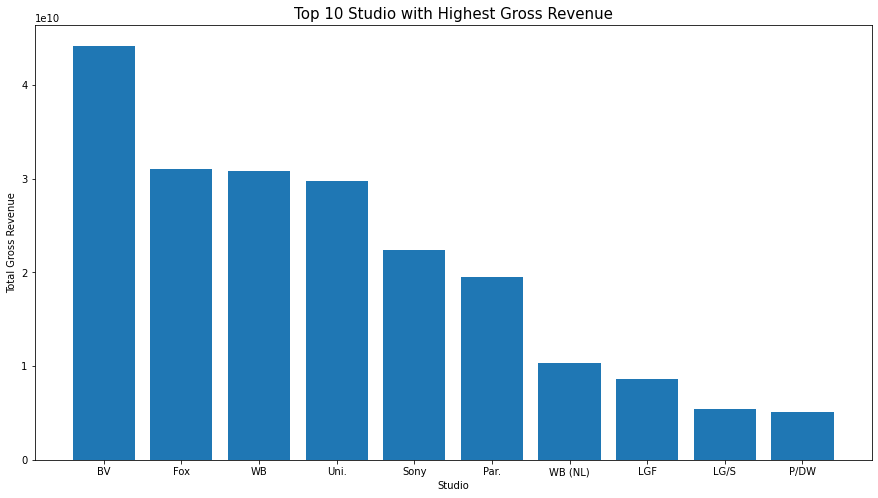

In [24]:
stud = df1.groupby('studio').sum()
stud.sort_values(by=['total_gross'], ascending = False, inplace = True)

fig, ax = plt.subplots(figsize = (15,8))
plt.bar(x = stud.index[:10], height = stud['total_gross'][:10])
plt.title('Top 10 Studio with Highest Gross Revenue', fontsize = 15)
plt.xlabel('Studio')
plt.ylabel('Total Gross Revenue')
plt.show();

### 2. Worldwide Gross Revenue Distributed by Released Months

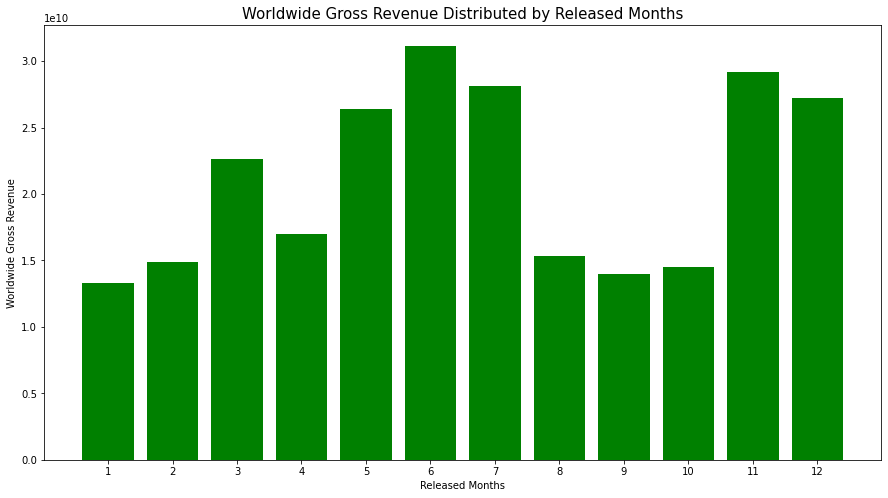

In [25]:
release_month = df23.groupby('release_month').sum()

fig, ax = plt.subplots(figsize = (15,8))
plt.bar(x = release_month.index, height = release_month['worldwide_gross'], color = 'green')
plt.xticks(range(1,13))
plt.xlabel('Released Months')
plt.ylabel('Worldwide Gross Revenue')
plt.title('Worldwide Gross Revenue Distributed by Released Months', fontsize = 15)
plt.show();

## Conclusions

### Limitations

### Recommendations